Opening connection
iTCLab connected via Arduino on port /dev/ttyACM0
LED On
Running Main Loop. Ctrl-C to end.
  Time     SP     PV     Q1   =  P   +  I  +   D
   0.0  25.00  29.92   0.00   0.00   0.00   0.00


<Figure size 720x504 with 0 Axes>

   1.0  25.00  29.48   0.00 -44.80   0.00   4.44


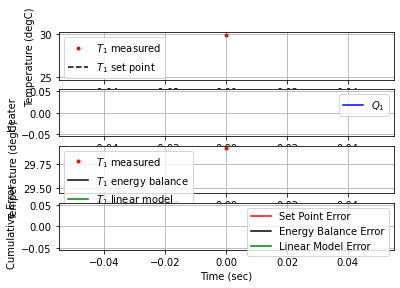

   3.9  25.00  29.53   0.00 -45.30   0.00  -0.17


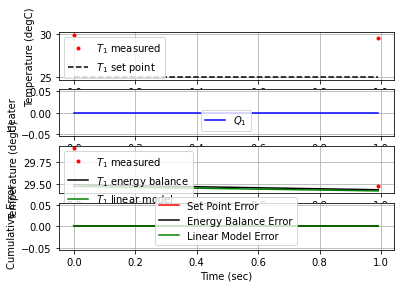

   6.1  25.00  29.36   0.00 -43.60   0.00   0.77


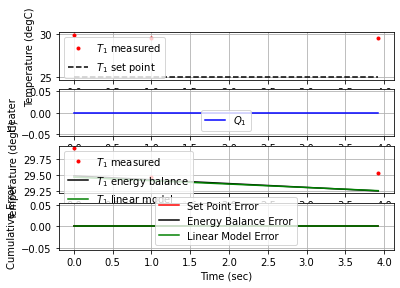

   8.5  25.00  29.18   0.00 -41.80   0.00   0.75


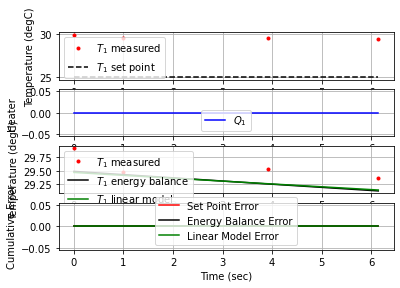

  11.0  25.00  29.03   0.00 -40.30   0.00   0.61


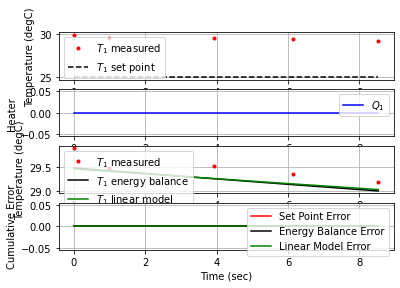

  13.1  25.00  28.99   0.00 -39.90   0.00   0.19


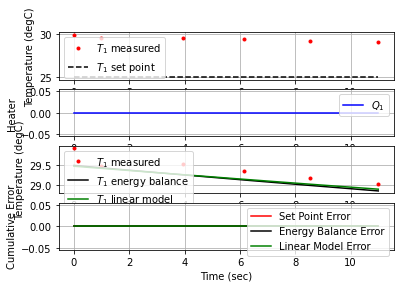

  15.4  25.00  28.91   0.00 -39.10   0.00   0.34


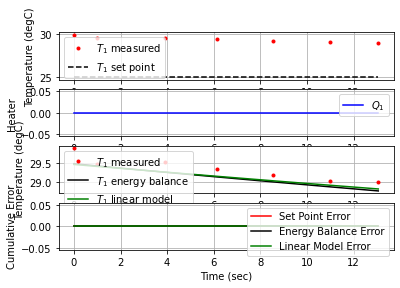

  18.1  25.00  28.76   0.00 -37.60   0.00   0.57


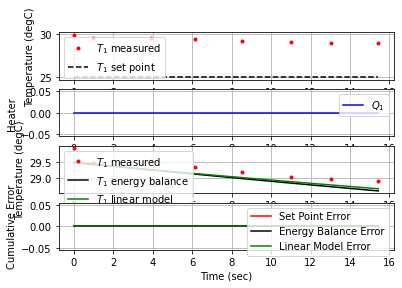

  20.3  25.00  28.66   0.00 -36.60   0.00   0.45
Shutting down
Arduino disconnected successfully
Arduino disconnected successfully


True

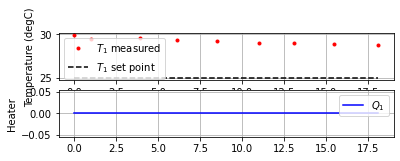

In [2]:
import itclab
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.integrate import odeint

######################################################
# Use this script for evaluating model predictions   #
# and PID controller performance for the TCLab       #
# Adjust only PID and model sections                 #
######################################################

######################################################
# PID Controller                                     #
######################################################
# inputs -----------------------------------
# sp = setpoint
# pv = current temperature
# pv_last = prior temperature
# ierr = integral error
# dt = time increment between measurements
# outputs ----------------------------------
# op = output of the PID controller
# P = proportional contribution
# I = integral contribution
# D = derivative contribution
def pid(sp,pv,pv_last,ierr,dt):
    Kc   = 10.0 # K/%Heater
    tauI = 50.0 # sec
    tauD = 1.0  # sec
    # Parameters in terms of PID coefficients
    KP = Kc
    KI = Kc/tauI
    KD = Kc*tauD
    # ubias for controller (initial heater)
    op0 = 0 
    # upper and lower bounds on heater level
    ophi = 100
    oplo = 0
    # calculate the error
    error = sp-pv
    # calculate the integral error
    ierr = ierr + KI * error * dt
    # calculate the measurement derivative
    dpv = (pv - pv_last) / dt
    # calculate the PID output
    P = KP * error
    I = ierr
    D = -KD * dpv
    op = op0 + P + I + D
    # implement anti-reset windup
    if op < oplo or op > ophi:
        I = I - KI * error * dt
        # clip output
        op = max(oplo,min(ophi,op))
    # return the controller output and PID terms
    return [op,P,I,D]

######################################################
# FOPDT model                                        #
######################################################
Kp = 0.5      # degC/%
tauP = 120.0  # seconds
thetaP = 10   # seconds (integer)
Tss = 23      # degC (ambient temperature)
Qss = 0       # % heater

######################################################
# Energy balance model                               #
######################################################
def heat(x,t,Q):
    # Parameters
    Ta = 23 + 273.15   # K
    U = 10.0           # W/m^2-K
    m = 4.0/1000.0     # kg
    Cp = 0.5 * 1000.0  # J/kg-K    
    A = 12.0 / 100.0**2 # Area in m^2
    alpha = 0.01       # W / % heater
    eps = 0.9          # Emissivity
    sigma = 5.67e-8    # Stefan-Boltzman

    # Temperature State 
    T = x[0]

    # Nonlinear Energy Balance
    dTdt = (1.0/(m*Cp))*(U*A*(Ta-T) \
            + eps * sigma * A * (Ta**4 - T**4) \
            + alpha*Q)
    return dTdt

######################################################
# Do not adjust anything below this point            #
######################################################

# Connect to Arduino
a = itclab.iTCLab()

# Turn LED on
print('LED On')
a.LED(100)

# Run time in minutes
run_time = 15.0

# Number of cycles
loops = int(60.0*run_time)
tm = np.zeros(loops)

# Temperature
# set point (degC)
Tsp1 = np.ones(loops) * 25.0 
Tsp1[60:] = 45.0
Tsp1[360:] = 30.0
Tsp1[660:] = 35.0
T1 = np.ones(loops) * a.T1 # measured T (degC)
error_sp = np.zeros(loops)

Tsp2 = np.ones(loops) * 23.0 # set point (degC)
T2 = np.ones(loops) * a.T2 # measured T (degC)

# Predictions
Tp = np.ones(loops) * a.T1
error_eb = np.zeros(loops)
Tpl = np.ones(loops) * a.T1
error_fopdt = np.zeros(loops)

# impulse tests (0 - 100%)
Q1 = np.ones(loops) * 0.0
Q2 = np.ones(loops) * 0.0

print('Running Main Loop. Ctrl-C to end.')
print('  Time     SP     PV     Q1   =  P   +  I  +   D')
print(('{:6.1f} {:6.2f} {:6.2f} ' + \
       '{:6.2f} {:6.2f} {:6.2f} {:6.2f}').format( \
           tm[0],Tsp1[0],T1[0], \
           Q1[0],0.0,0.0,0.0))

# Create plot
plt.figure(figsize=(10,7))
plt.ion()
plt.show()

# Main Loop
start_time = time.time()
prev_time = start_time
# Integral error
ierr = 0.0
try:
    for i in range(1,loops):
        # Sleep time
        sleep_max = 1.0
        sleep = sleep_max - (time.time() - prev_time)
        if sleep>=0.01:
            time.sleep(sleep-0.01)
        else:
            time.sleep(0.01)

        # Record time and change in time
        t = time.time()
        dt = t - prev_time
        prev_time = t
        tm[i] = t - start_time

        # Read temperatures in Kelvin 
        T1[i] = a.T1
        T2[i] = a.T2

        # Simulate one time step with Energy Balance
        Tnext = odeint(heat,Tp[i-1]+273.15,[0,dt],args=(Q1[i-1],))
        Tp[i] = Tnext[1]-273.15

        # Simulate one time step with linear FOPDT model
        z = np.exp(-dt/tauP)
        Tpl[i] = (Tpl[i-1]-Tss) * z \
                 + (Q1[max(0,i-int(thetaP)-1)]-Qss)*(1-z)*Kp \
                 + Tss

        # Calculate PID output
        [Q1[i],P,ierr,D] = pid(Tsp1[i],T1[i],T1[i-1],ierr,dt)

        # Start setpoint error accumulation after 1 minute (60 seconds)
        if i>=60:
            error_eb[i] = error_eb[i-1] + abs(Tp[i]-T1[i])
            error_fopdt[i] = error_fopdt[i-1] + abs(Tpl[i]-T1[i])
            error_sp[i] = error_sp[i-1] + abs(Tsp1[i]-T1[i])

        # Write output (0-100)
        a.Q1(Q1[i])
        a.Q2(0.0)

        # Print line of data
        print(('{:6.1f} {:6.2f} {:6.2f} ' + \
              '{:6.2f} {:6.2f} {:6.2f} {:6.2f}').format( \
                  tm[i],Tsp1[i],T1[i], \
                  Q1[i],P,ierr,D))

        # Plot
        plt.clf()
        ax=plt.subplot(4,1,1)
        ax.grid()
        plt.plot(tm[0:i],T1[0:i],'r.',label=r'$T_1$ measured')
        plt.plot(tm[0:i],Tsp1[0:i],'k--',label=r'$T_1$ set point')
        plt.ylabel('Temperature (degC)')
        plt.legend(loc=2)
        ax=plt.subplot(4,1,2)
        ax.grid()
        plt.plot(tm[0:i],Q1[0:i],'b-',label=r'$Q_1$')
        plt.ylabel('Heater')
        plt.legend(loc='best')
        ax=plt.subplot(4,1,3)
        ax.grid()
        plt.plot(tm[0:i],T1[0:i],'r.',label=r'$T_1$ measured')
        plt.plot(tm[0:i],Tp[0:i],'k-',label=r'$T_1$ energy balance')
        plt.plot(tm[0:i],Tpl[0:i],'g-',label=r'$T_1$ linear model')
        plt.ylabel('Temperature (degC)')
        plt.legend(loc=2)
        ax=plt.subplot(4,1,4)
        ax.grid()
        plt.plot(tm[0:i],error_sp[0:i],'r-',label='Set Point Error')
        plt.plot(tm[0:i],error_eb[0:i],'k-',label='Energy Balance Error')
        plt.plot(tm[0:i],error_fopdt[0:i],'g-',label='Linear Model Error')
        plt.ylabel('Cumulative Error')
        plt.legend(loc='best')
        plt.xlabel('Time (sec)')
        plt.draw()
        plt.pause(0.05)

    # Turn off heaters
    a.Q1(0)
    a.Q2(0)
    # Save figure
    plt.savefig('test_PID.png')

# Allow user to end loop with Ctrl-C           
except KeyboardInterrupt:
    # Disconnect from Arduino
    a.Q1(0)
    a.Q2(0)
    print('Shutting down')
    a.close()
    plt.savefig('test_PID.png')

# Make sure serial connection still closes when there's an error
except:           
    # Disconnect from Arduino
    a.Q1(0)
    a.Q2(0)
    print('Error: Shutting down')
    a.close()
    plt.savefig('test_PID.png')
    raise

a.close()

In [ ]:
a.close()

Arduino disconnected successfully


True